In [1]:
from boiles.objective.simulation2d import Simulation2D
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import gym
import os
import numpy as np
from models.envs.implosion import ImplosionEnv, ImplosionHighResEnv
from models.envs.riemann2d import Riemann2D3Env
from models.envs.shear_flow import ShearFlowEnv, ShearFlowHighResEnv
from models.utils import write_to_csv
from models.networks import CustomCNN
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from IPython.display import clear_output
from stable_baselines3 import A2C, PPO
from stable_baselines3 import DQN
from stable_baselines3.common.utils import set_random_seed

seed = 100
set_random_seed(seed)
os.system("rm -rf ./test_board/PPO_0")
reward_his = []
quality_list = [["iteration", "quality"]]

In [2]:
def plot_subplot(index, value, bounds=[0, 1]):
    plt.subplot(index)
    value = (value - value.min()) / (value.max() - value.min())
    plt.imshow(value, vmin=bounds[0], vmax=bounds[1], origin="lower")
    plt.colorbar()

def plot_states(end_times, states, iterations=None):
    frames = len(end_times)
    for state in states:
        plt.figure(figsize=(frames*6, frames), dpi=150)
        index = 100 + frames * 10 + 1
        for i, end_time in enumerate(end_times):
            freeshear = Simulation2D(results_folder=f"runtime_data/{env.inputfile}_{end_time}/domain", result_filename=f"data_{end_time}*.h5") 
            
            vor = freeshear.result[state]
            plot_subplot(index, vor)
            index += 1
            plt.title(f"{state} ({end_time[:-1]}s)")
        if iterations is not None:
            plt.savefig(f"full_implosion_figures/{state}_{str(iterations)}.jpg")
        plt.show()
def final_ke(folder):
    freeshear = Simulation2D(results_folder=f"{folder}/domain/", result_filename="data_2.500*.h5")
    vel_x = freeshear.result["velocity"]["velocity_x"]
    vel_y = freeshear.result["velocity"]["velocity_y"]
    density = freeshear.result["density"]
    x = 0.4 / 64
    ke = 0.5 * density * (vel_x**2 + vel_y**2)
    print("fianl_ke: ", ke.sum())

In [3]:
import math

def plot_cnn_layer(state):
    if state[0].dim() != 1:
        _, layers, _, _ = state.shape
        rows_num = math.ceil(layers / 9)
    #     print(layers, rows_num)
        plt.figure(figsize=(24, 3 * rows_num))
        for i in range(layers):
            plt.subplot(rows_num, 9, i+1)
            plt.imshow(state[0, i].detach().numpy())
            plt.colorbar(fraction=0.03)
        
    else:
        plt.figure(figsize=(24, 3))
        plt.plot(state[0].detach().numpy())
        plt.grid()
    plt.show()

In [4]:
env = ImplosionEnv()
env.reset(evaluate=False)
steps = int(env.end_time / env.timestep_size)
print(env)

/home/yiqi/Software/envs/gpytorch/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


ImplosionEnv Summary:

	Inputfile: implosion_64
	Timespan: (0, 2.5); Timestep size: 0.1
	Parameters: q (1, 10); Cq (1, 100); Eta (0.1, 0.9)
	Layers: ['density', 'kinetic_energy', 'pressure']
	Smoothness: 0.33
	Baseline data: /home/yiqi/PycharmProjects/RL2D/baseline/implosion_64/domain

	Executable: /home/yiqi/PycharmProjects/RL2D/solvers/ALPACA_32_TENO5RL_ETA
	Core num: 4


In [5]:
policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=64),
    normalize_images=False
)
model = PPO("CnnPolicy", env, n_steps=8*steps, batch_size=4*steps, device='cpu', gamma=0.99, tensorboard_log="./test_board/", policy_kwargs=policy_kwargs)

2048


q, cq, d1, d2, eta: (10, 1  , 0.622, 0.257, 0.486)   si_penalty: 0.000   Improve (si, ke)=1 , 0  Reward: -0.047   Quality: -0.004699842267540721
q, cq, d1, d2, eta: (1 , 22 , 0.725, 0.050, 0.900)   si_penalty: 0.023   Improve (si, ke)=0 , 1  Reward: 0.029    Quality: -0.001750782234700897
q, cq, d1, d2, eta: (5 , 1  , 0.725, 0.050, 0.900)   si_penalty: 0.002   Improve (si, ke)=0 , 0  Reward: -0.035   Quality: -0.00520621103978555
q, cq, d1, d2, eta: (10, 1  , 0.667, 0.166, 0.669)   si_penalty: 0.000   Improve (si, ke)=1 , 0  Reward: -0.040   Quality: -0.009255414525560194
q, cq, d1, d2, eta: (8 , 1  , 0.725, 0.050, 0.900)   si_penalty: 0.000   Improve (si, ke)=1 , 1  Reward: 0.020    Quality: -0.007249583074495939
q, cq, d1, d2, eta: (1 , 9  , 0.725, 0.050, 0.900)   si_penalty: 0.070   Improve (si, ke)=0 , 1  Reward: -0.135   Quality: -0.02071595530033951
q, cq, d1, d2, eta: (7 , 1  , 0.725, 0.050, 0.900)   si_penalty: 0.000   Improve (si, ke)=1 , 1  Reward: 0.004    Quality: -0.020354

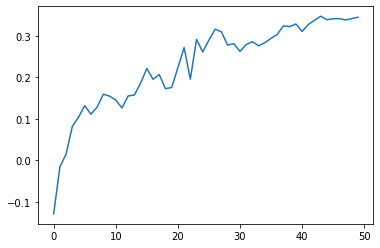

fianl_ke:  16.007089242261394


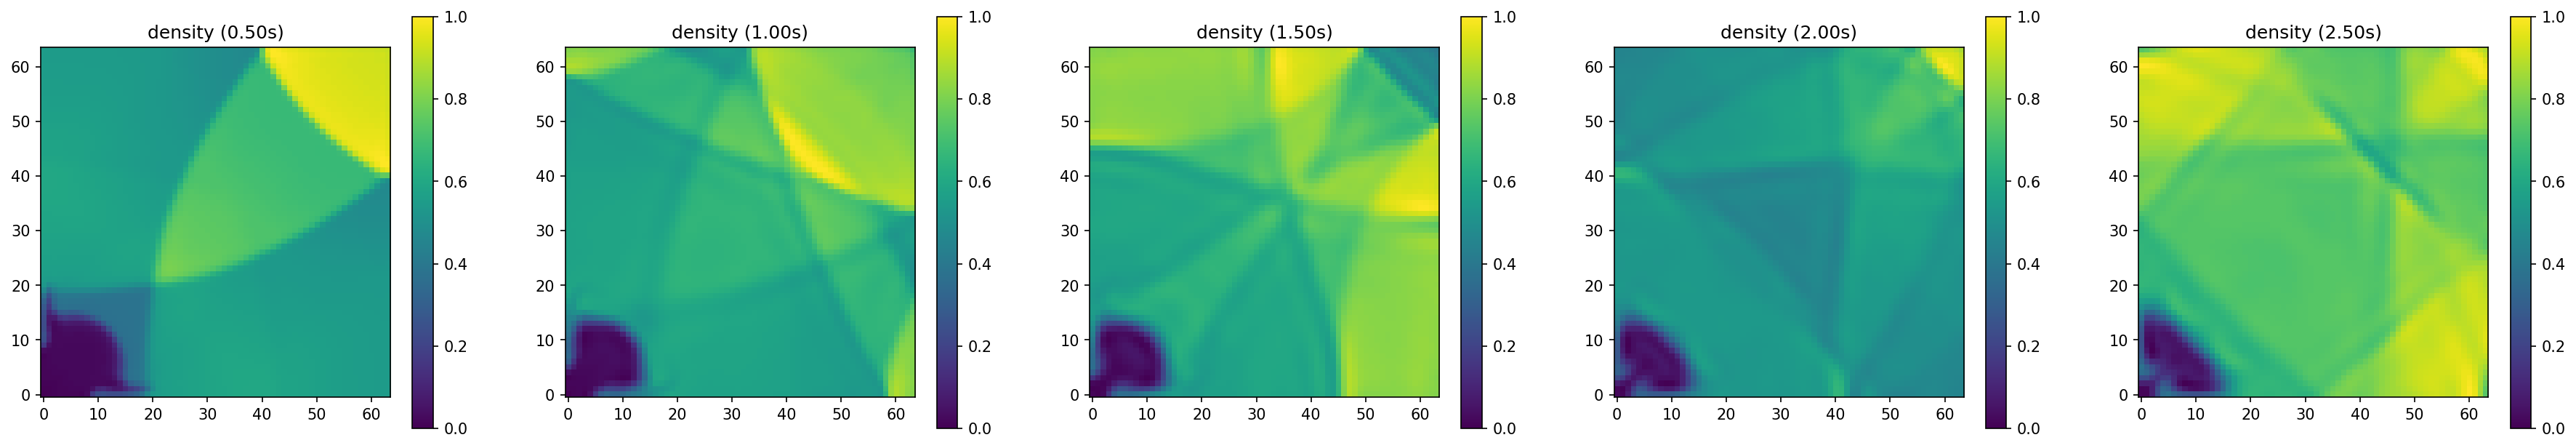

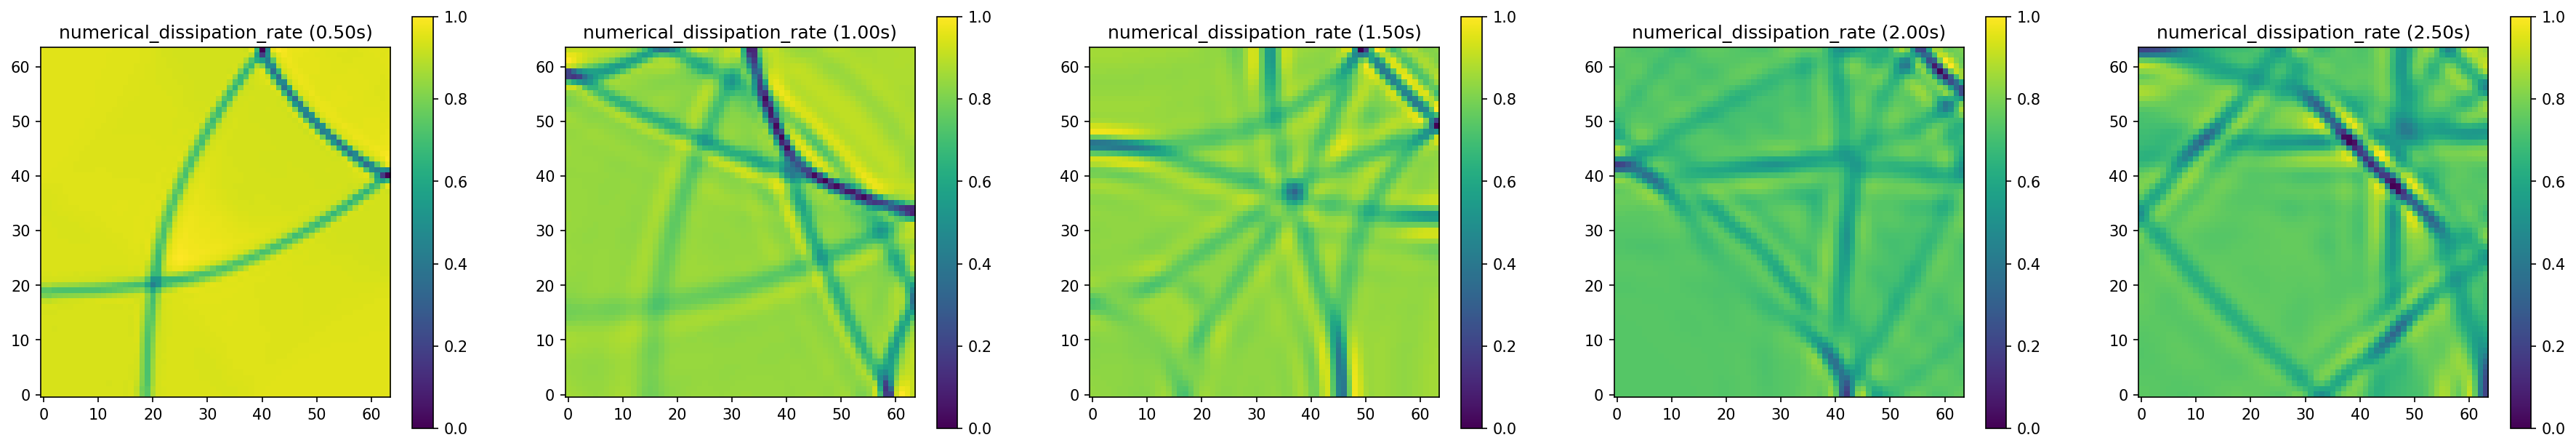

In [6]:
# os.system("rm -rf full_implosion_model")
# os.system("mkdir full_implosion_model")
# reward_his = []

model.set_env(env)
quality_list_plot = []
for i in range(50):
    env.reset(evaluate=False)
    model.policy.float()
    model.learn(total_timesteps=8*steps, n_eval_episodes=2, eval_freq=5, log_interval=1, reset_num_timesteps=False)
    
    obs = env.reset(evaluate=True)
    dones = False
    j = 1
    cumulative_reward = 0
    rate = 0
    while not dones:
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, dones, info = env.step(action)
        j += 1
        cumulative_reward += rewards
    print(f"cumulative_reward of {i+1}: ", format(cumulative_reward, ".4f"))
    print(f"cumulative_quality of {i+1}: ", format(env.quality, ".4f"))
    quality_list.append([i+1, env.quality])
    write_to_csv(f"ppo_models/quality_cqq_{seed}.csv", quality_list)
    reward_his.append(cumulative_reward)
    quality_list_plot.append(env.quality)
    plt.plot(quality_list_plot)
    plt.show()
    try:
        final_ke(folder=f"runtime_data/{env.inputfile}_2.500/")
        plot_states(
            end_times=["0.500", "1.000", "1.500", "2.000", "2.500"], 
            states=["density", "numerical_dissipation_rate"]
        )
    except:
        clear_output(wait=True)
    model.save(f"ppo_models/implosion_model_cqq_{seed}_{i}.zip")
    clear_output(wait=True)

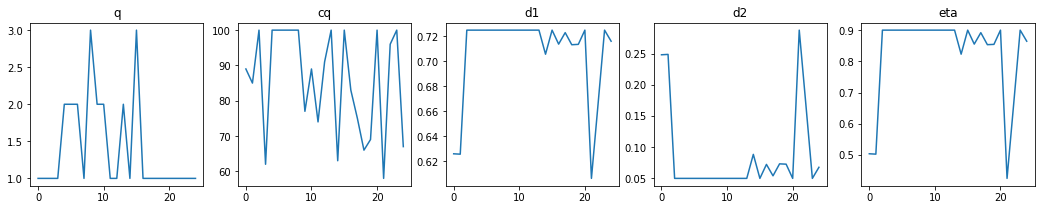

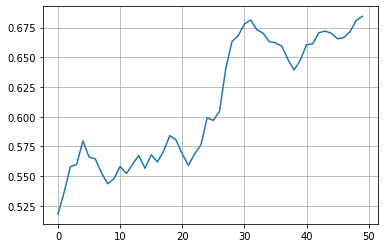

In [7]:
action_traj = np.array(env.action_trajectory)
label = ["q", "cq", "d1", "d2", "eta"]
plt.figure(figsize=(18, 3))
for i in range(5):
    plt.subplot(1, 5, 1+i)
    plt.plot(action_traj[:, i])
    plt.title(label[i])
plt.show()
plt.plot(reward_his)
plt.grid()

2048


/home/yiqi/PycharmProjects/RL2D/models/envs/implosion.py:92: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  value = torch.nn.AvgPool2d(2)(torch.tensor([value]))[0].numpy()


q, cq, d1, d2, eta: (10, 1  , 0.622, 0.257, 0.486)   
q, cq, d1, d2, eta: (1 , 21 , 0.725, 0.050, 0.900)   
q, cq, d1, d2, eta: (4 , 1  , 0.725, 0.050, 0.900)   
q, cq, d1, d2, eta: (10, 1  , 0.667, 0.167, 0.667)   
q, cq, d1, d2, eta: (8 , 1  , 0.725, 0.050, 0.900)   
q, cq, d1, d2, eta: (1 , 2  , 0.725, 0.050, 0.900)   
q, cq, d1, d2, eta: (6 , 1  , 0.725, 0.050, 0.900)   
q, cq, d1, d2, eta: (1 , 48 , 0.725, 0.050, 0.900)   
q, cq, d1, d2, eta: (1 , 2  , 0.725, 0.050, 0.900)   
q, cq, d1, d2, eta: (5 , 1  , 0.725, 0.050, 0.900)   
q, cq, d1, d2, eta: (1 , 92 , 0.725, 0.050, 0.900)   
q, cq, d1, d2, eta: (1 , 38 , 0.725, 0.050, 0.900)   
q, cq, d1, d2, eta: (1 , 52 , 0.725, 0.050, 0.900)   
q, cq, d1, d2, eta: (1 , 97 , 0.725, 0.050, 0.900)   
q, cq, d1, d2, eta: (1 , 59 , 0.725, 0.050, 0.900)   
q, cq, d1, d2, eta: (1 , 71 , 0.725, 0.050, 0.900)   
q, cq, d1, d2, eta: (1 , 68 , 0.725, 0.050, 0.900)   
q, cq, d1, d2, eta: (1 , 47 , 0.725, 0.050, 0.900)   
q, cq, d1, d2, eta: (1 , 77 

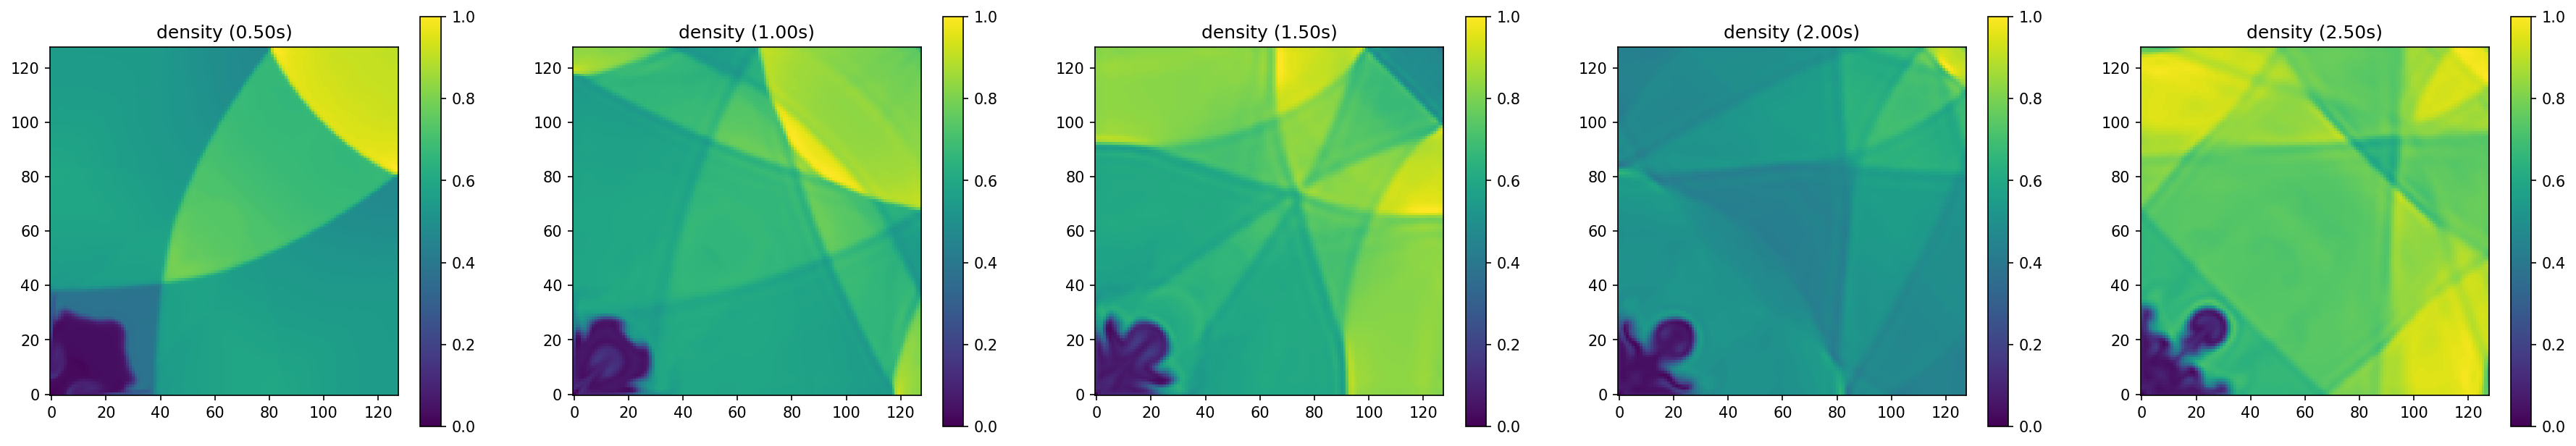

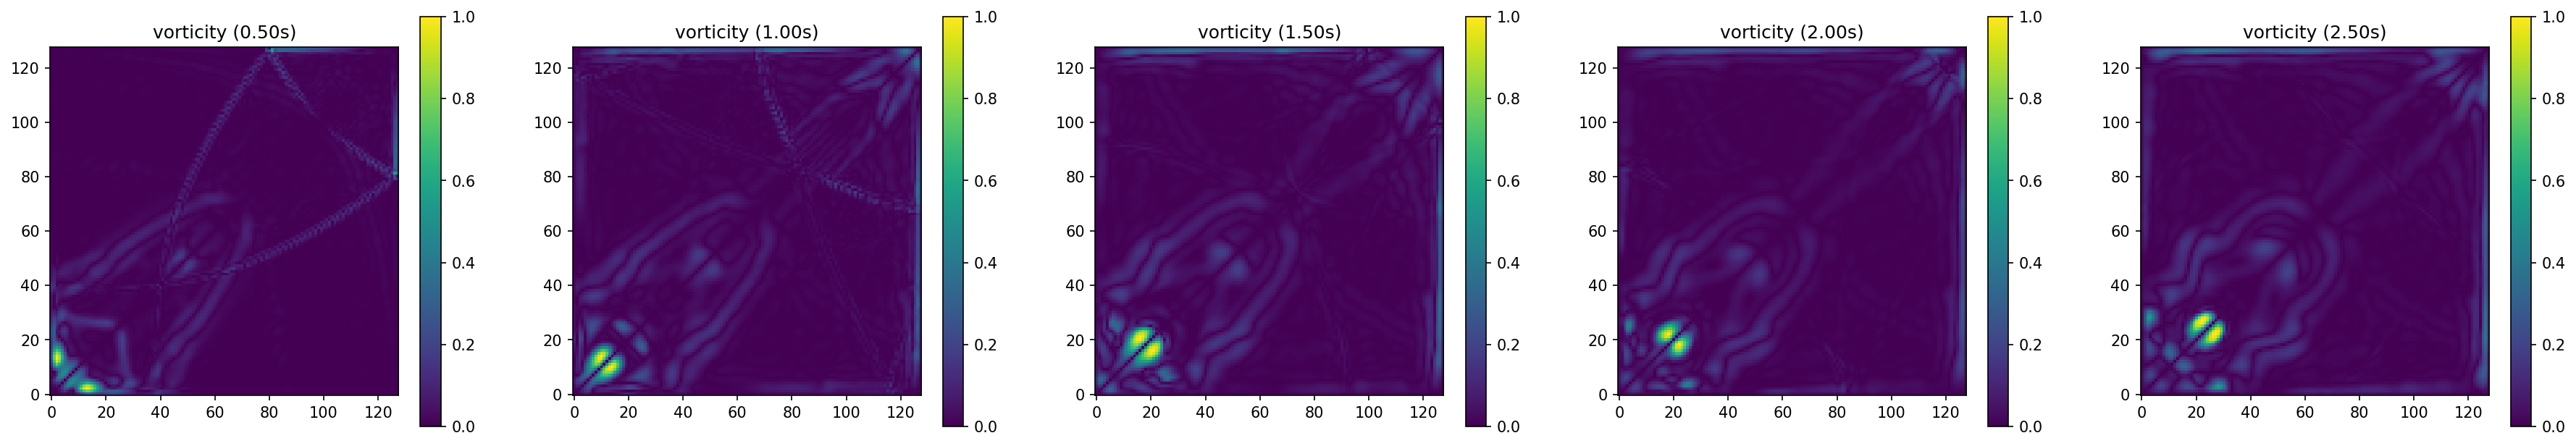

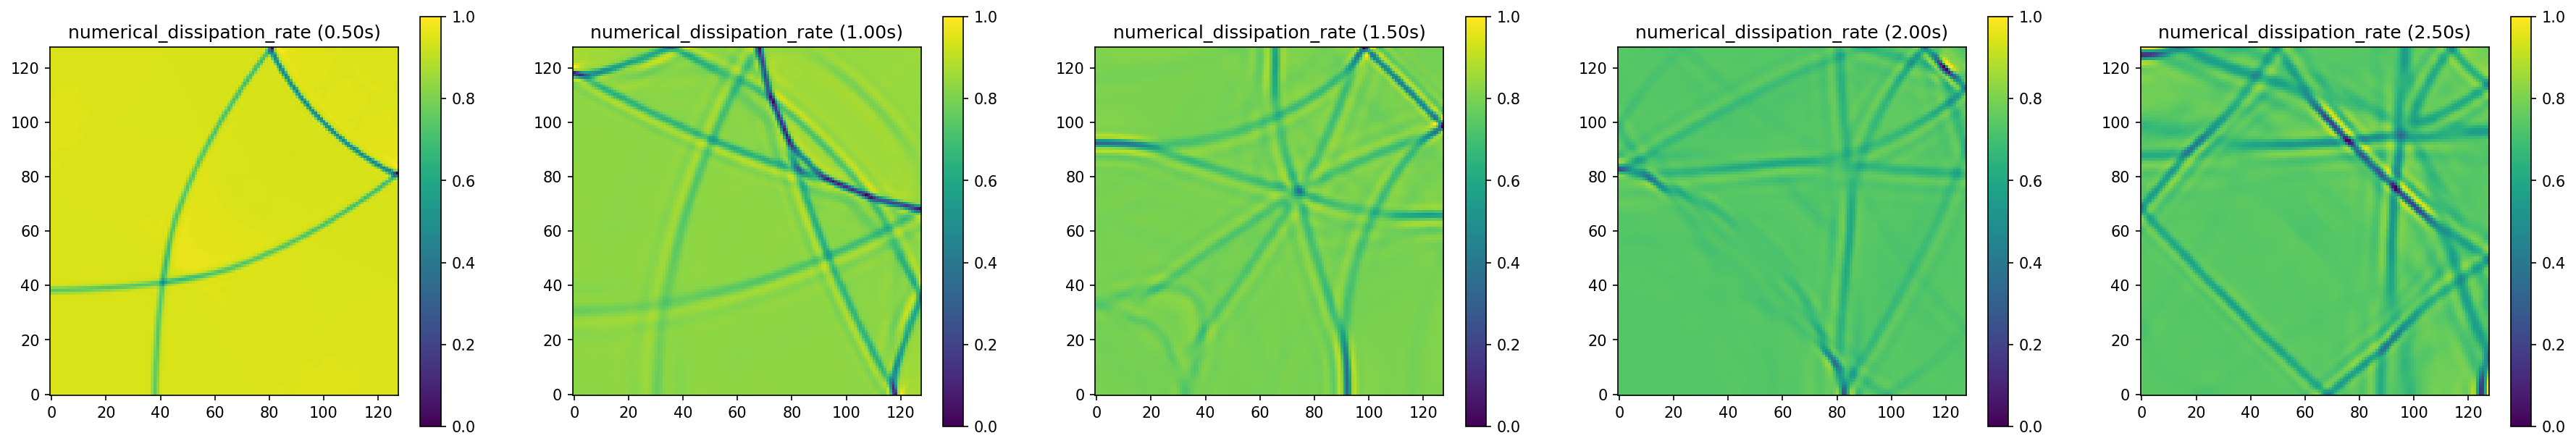

In [8]:
env = ImplosionHighResEnv()
# env = FullImplosionEnv()
# del model
model = PPO.load("ppo_models/implosion_model_cqq_49.zip", env=env, device="cpu")
model.policy.float()
obs = env.reset(evaluate=True)
obs_list = []
dones = False
i = 0
while not dones:
    obs_list.append(obs)
    action, _states = model.predict(obs, deterministic=True)
#     action = raw_actions_64[i]
#     action = [0, 0, 0]
    i += 1
    obs, rewards, dones, info = env.step(action)
try:
    final_ke(folder=f"runtime_data/{env.inputfile}_2.500/")
    plot_states(
        end_times=["0.500", "1.000", "1.500", "2.000", "2.500"], 
        states=["density", "vorticity", "numerical_dissipation_rate"]
    )
except:
    clear_output(wait=True)
# model.save(f"full_implosion_model/full_implosion_model_{i}.zip")
clear_output(wait=True)

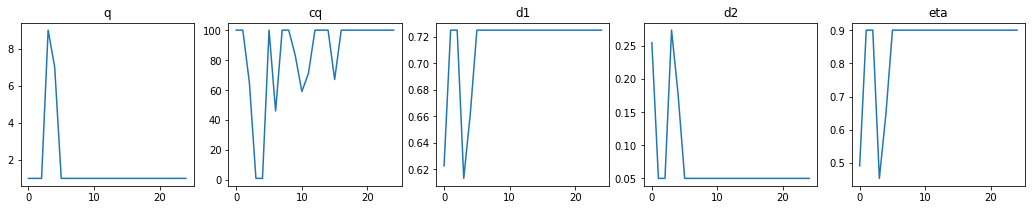

In [7]:
action_traj_128 = np.array(env.action_trajectory)
label = ["q", "cq", "d1", "d2", "eta"]
plt.figure(figsize=(18, 3))
for i in range(5):
    plt.subplot(1, 5, 1+i)
    plt.plot(action_traj_128[:, i])
    plt.title(label[i])
plt.show()

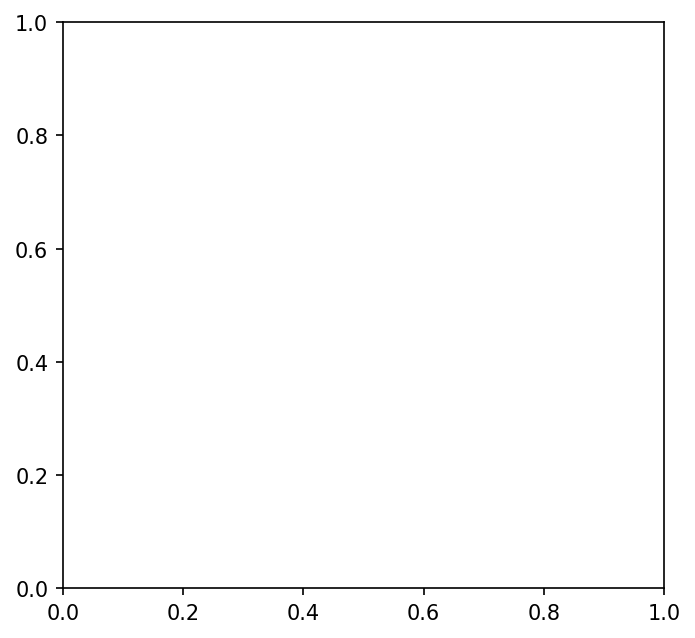

In [7]:
# env = HighResFullImplosionEnv()
raw_actions_64 = []
env = ImplosionEnv()
del model
model = PPO.load("ppo_models/implosion_model_cqq_49.zip", env=env)
model.policy.float()
obs = env.reset(evaluate=True)
obs_list = []
dones = False
while not dones:
    obs_list.append(obs)
    action, _states = model.predict(obs, deterministic=True)
#     action = [-0.8, 0.8, -0.8]
    raw_actions_64.append(action)
    obs, rewards, dones, info = env.step(action)
try:
    final_ke(folder=f"runtime_data/{env.inputfile}_2.500/")
    plot_states(
        end_times=["0.500", "1.000", "1.500", "2.000", "2.500"], 
        states=["density", "schlieren", "vorticity", "numerical_dissipation_rate"]
    )
except:
    clear_output(wait=True)
# model.save(f"full_implosion_model/full_implosion_model_{i}.zip")
clear_output(wait=True)

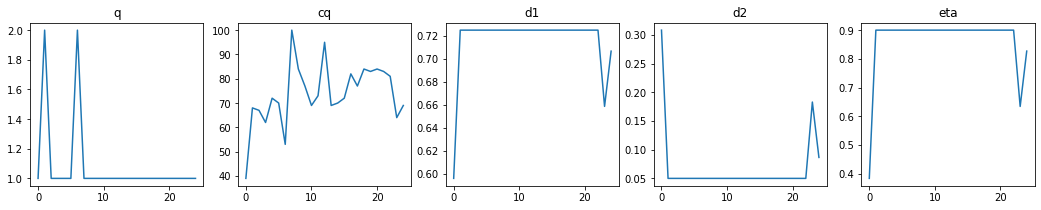

In [11]:
action_traj_64 = np.array(env.action_trajectory)
label = ["q", "cq", "d1", "d2", "eta"]
plt.figure(figsize=(18, 3))
for i in range(5):
    plt.subplot(1, 5, 1+i)
    plt.plot(action_traj_64[:, i])
    plt.title(label[i])
plt.show()

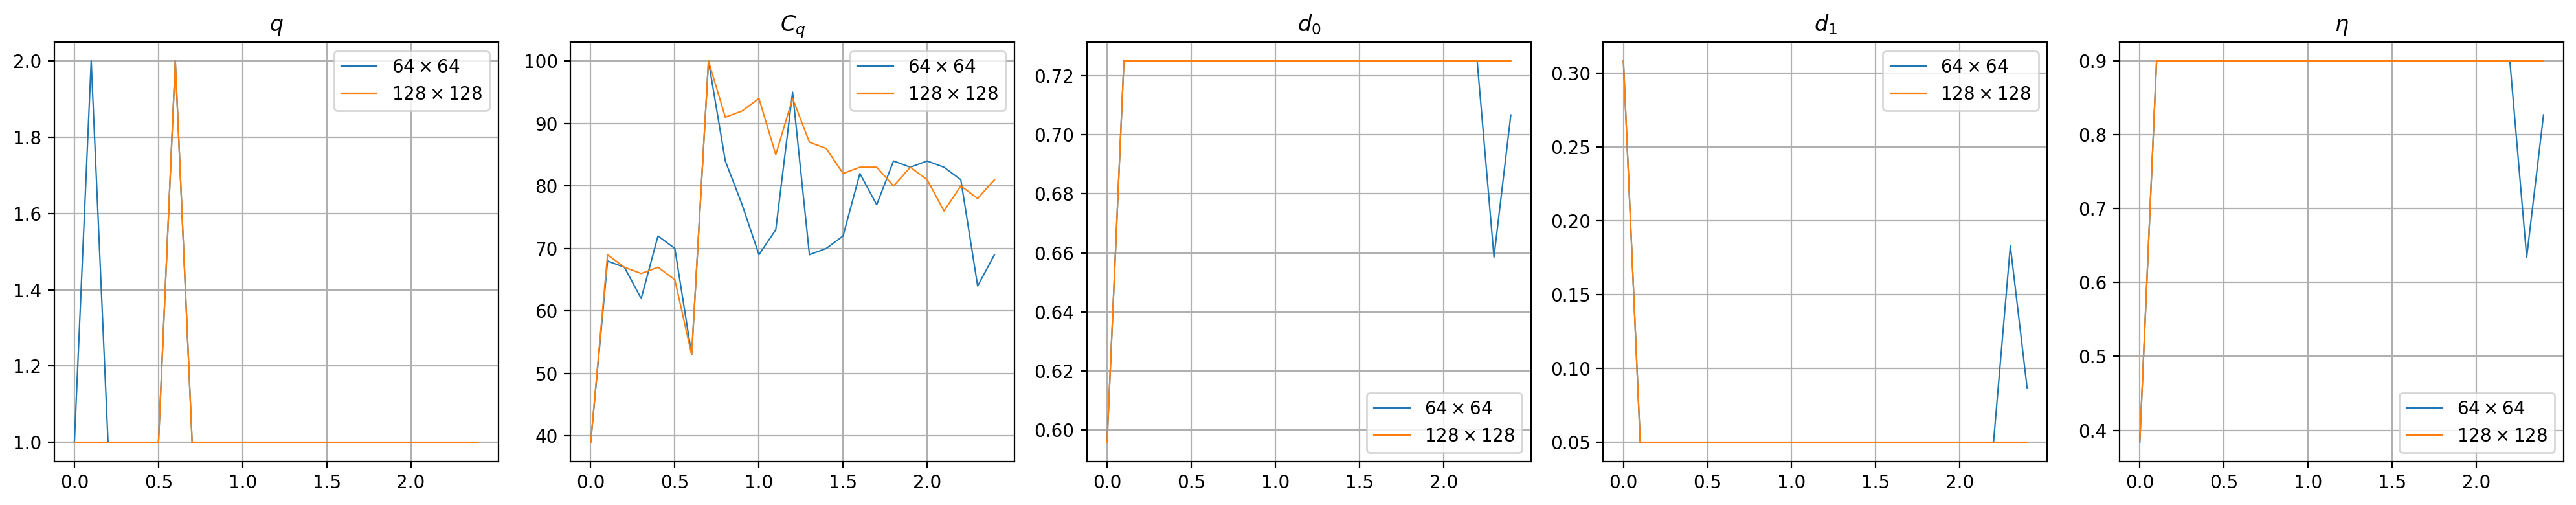

In [12]:
label = ["$q$", "$C_q$", "$d_0$", "$d_1$", r"$\eta$"]
x_64 = np.arange(0, 2.5, 0.1)
x_128 = np.arange(0, 2.5, 0.1)
plt.figure(figsize=(20, 4), dpi=200)
for i in range(5):
    plt.subplot(1, 5, 1+i)
    plt.plot(x_64, action_traj_64[:, i], linewidth=0.8, label=r"$64\times64$")
    plt.plot(x_128, action_traj_128[:, i], linewidth=0.8, label=r"$128\times128$")
    plt.title(label[i])
    plt.xticks(x_64[::5])
    plt.legend()
    plt.grid()
plt.tight_layout()
# plt.show()
# plt.savefig("/media/yiqi/Fengyiqi/TUM/RL/action_traj.jpg")

In [ ]:
layers = len(model.policy.features_extractor.cnn) 
obs_seq = 10
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(obs_list[obs_seq][0])
plt.colorbar()
plt.subplot(132)
plt.imshow(obs_list[obs_seq][1])
plt.colorbar()
plt.subplot(133)
plt.imshow(obs_list[obs_seq][2])
plt.colorbar()
plt.show()
state = torch.tensor(np.expand_dims(obs_list[obs_seq], axis=0), dtype=torch.double)


for i in range(layers):
    print("layer ", i+1, str(model.policy.features_extractor.cnn[i]))
    cnn = model.policy.features_extractor.cnn[i].double().cpu()
    if isinstance(cnn, nn.BatchNorm2d):
        continue
    state = cnn(state)
    plot_cnn_layer(state)
# layers

In [ ]:
layers = len(model.policy.features_extractor.cnn) 
obs_seq = 40
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(obs_list[obs_seq][0])
plt.colorbar()
plt.subplot(132)
plt.imshow(obs_list[obs_seq][1])
plt.colorbar()
plt.subplot(133)
plt.imshow(obs_list[obs_seq][2])
plt.colorbar()
plt.show()
state = torch.tensor(np.expand_dims(obs_list[obs_seq], axis=0), dtype=torch.double)


for i in range(layers):
    print("layer ", i+1, str(model.policy.features_extractor.cnn[i]))
    cnn = model.policy.features_extractor.cnn[i].double()
    if isinstance(cnn, nn.BatchNorm2d):
        continue
    state = cnn(state)
    plot_cnn_layer(state)
# layers

In [ ]:
timesteps = np.arange(0, 2.5+0.01, 0.05)
q_list = [6, 8, 10, 12, 18]


ke_dict, dissipation_dict, dispersion_dict, energy_dict, abs_numerical_dict = {}, {}, {}, {}, {}

for q in q_list:
    ke_dict[q], dissipation_dict[q], dispersion_dict[q], energy_dict[q], abs_numerical_dict[q] = [], [], [], [], []
    
    for t in timesteps:
        end_time = format(t, ".3f")
        freeshear = FreeShearFlow(results_folder=f"full_implosion_test/full_implosion_q{q}/domain", result_filename=f"data_{end_time}*.h5")
        numerical_rate = freeshear.result["numerical_dissipation_rate"]
#         vorticity = freeshear.result["vorticity"]
        energy = freeshear.result["energy"]
        energy_dict[q].append(energy.sum() / 4096)
        dissipation = numerical_rate[numerical_rate > 0]
        dispersion = numerical_rate[numerical_rate < 0]
        dissipation_dict[q].append(dissipation.sum())
        dispersion_dict[q].append(dispersion.sum())
        numerical = (numerical_rate).sum()
        abs_numerical_dict[q].append(numerical)
        
        vel_x = freeshear.result["velocity"]["velocity_x"]
        vel_y = freeshear.result["velocity"]["velocity_y"]
        density = freeshear.result["density"]
        x = 0.4 / 64
        ke = 0.5 * density * (vel_x**2 + vel_y**2)
        ke_dict[q].append(ke.sum())
    ke_dict[q] = np.array(ke_dict[q])
#     plt.plot(timesteps, ke_dict[q], label=str(q), linewidth=0.6)

In [22]:
timesteps = np.arange(0.1, 2.5+0.01, 0.1)
q_list = [6, 8, 10, 12, 18]

folder_list = [
    "full_implosion/full_implosion_test/full_implosion_ori/domain",
    "full_implosion/full_implosion_test/full_implosion_q6/domain",
    "runtime_data",
#     "full_implosion/full_implosion_test/full_implosion_weno7/domain"
    "full_implosion/grid_search_64/full_implosion_64_weno9/domain"
]
labels = ["$TENO5_{ori}$", "$TENO5_{Lin}$", "$TENO5_{agent}$", "WENO9"]

def compute_ke_array(freeshear):
    vel_x = freeshear.result["velocity"]["velocity_x"]
    vel_y = freeshear.result["velocity"]["velocity_y"]
    density = freeshear.result["density"]
    ke = 0.5 * density * (vel_x**2 + vel_y**2)
    return ke

ke_dict, dissipation_dict, dispersion_dict, abs_numerical_dict, rel_numerical_dict = {}, {}, {}, {}, {}

for i, folder in enumerate(folder_list):
    ke_dict[i], dissipation_dict[i], dispersion_dict[i], rel_numerical_dict[i], abs_numerical_dict[i] = [], [], [], [], []
    
    for t in timesteps:
        end_time = format(t, ".3f")
        if folder == "runtime_data":
            freeshear = FreeShearFlow(results_folder=f"{folder}/full_implosion_64_{end_time}/domain", result_filename=f"data_{end_time}*.h5")
        else:
            freeshear = FreeShearFlow(results_folder=folder, result_filename=f"data_{end_time}*.h5")
        numerical_rate = freeshear.result["numerical_dissipation_rate"]
        dissipation = numerical_rate[numerical_rate > 0]
        dispersion = numerical_rate[numerical_rate < 0]
        dissipation_dict[i].append(dissipation.sum())
        dispersion_dict[i].append(dispersion.sum())
        
        rel_numerical_dict[i].append(numerical_rate.sum())
        abs_numerical_dict[i].append(abs(numerical_rate).sum())

        ke = compute_ke_array(freeshear)
        ke_dict[i].append(ke.sum())
        
#     plt.plot(timesteps, ke_dict[q], label=str(q), linewidth=0.6)

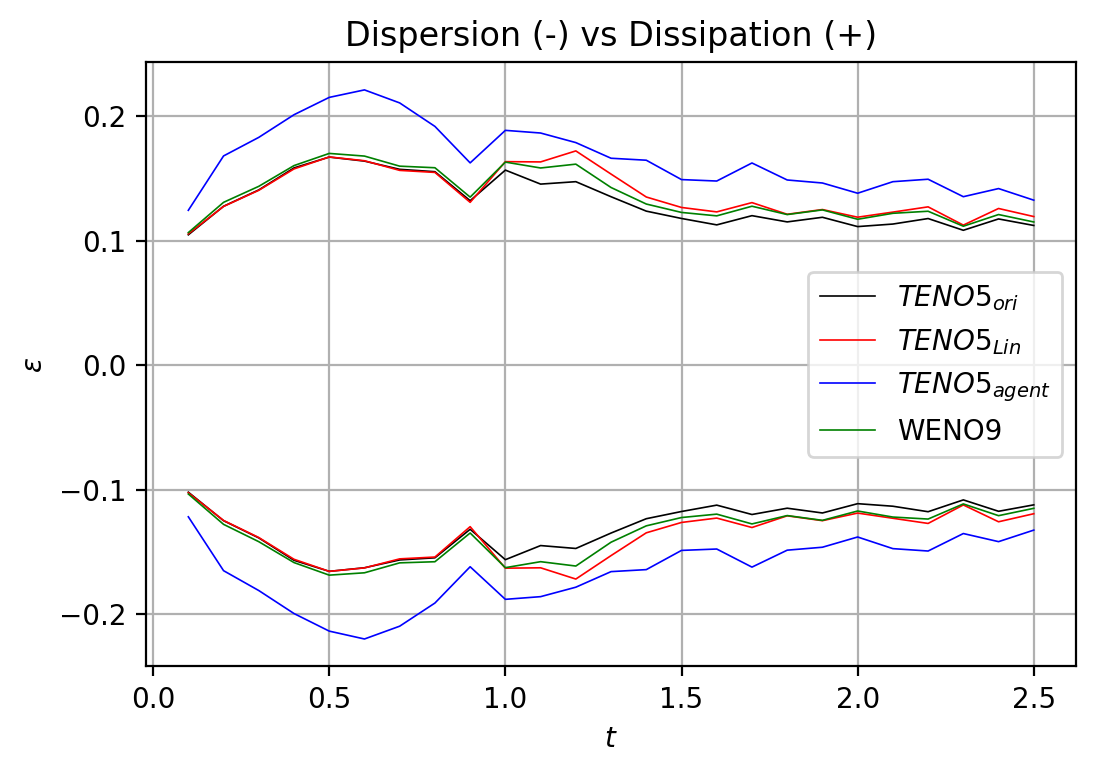

In [25]:
plt.figure(dpi=200)
colors = ["black", "red", "blue", "green", "orange"]
for i, label in enumerate(labels):
    plt.plot(timesteps, dissipation_dict[i], label=label, color=colors[i], linewidth=0.6)
    plt.plot(timesteps, dispersion_dict[i], color=colors[i], linewidth=0.6)
plt.legend()
plt.title("Dispersion (-) vs Dissipation (+)")
plt.ylabel("$\epsilon$")
plt.xlabel("$t$")
plt.grid()
# plt.show()
plt.savefig("/media/yiqi/Fengyiqi/TUM/RL/grid_search_figures/disper_diss_compare.jpg")

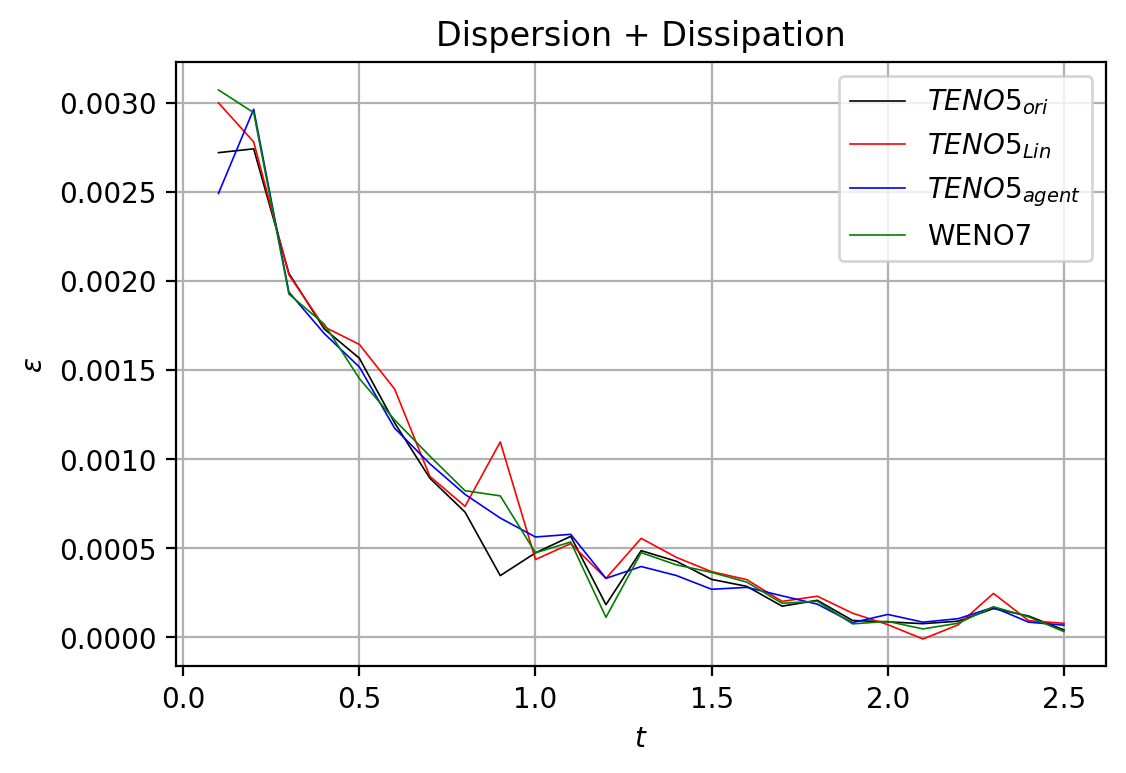

In [12]:
plt.figure(dpi=200)
colors = ["black", "red", "blue", "green", "orange"]
for i, label in enumerate(labels):
    plt.plot(timesteps, rel_numerical_dict[i], label=label, color=colors[i], linewidth=0.6)
plt.legend()
plt.title("Dispersion + Dissipation")
plt.ylabel("$\epsilon$")
plt.xlabel("$t$")
plt.grid()
# plt.show()
# plt.savefig("full_implosion_figures/rel_sum_rate.jpg")

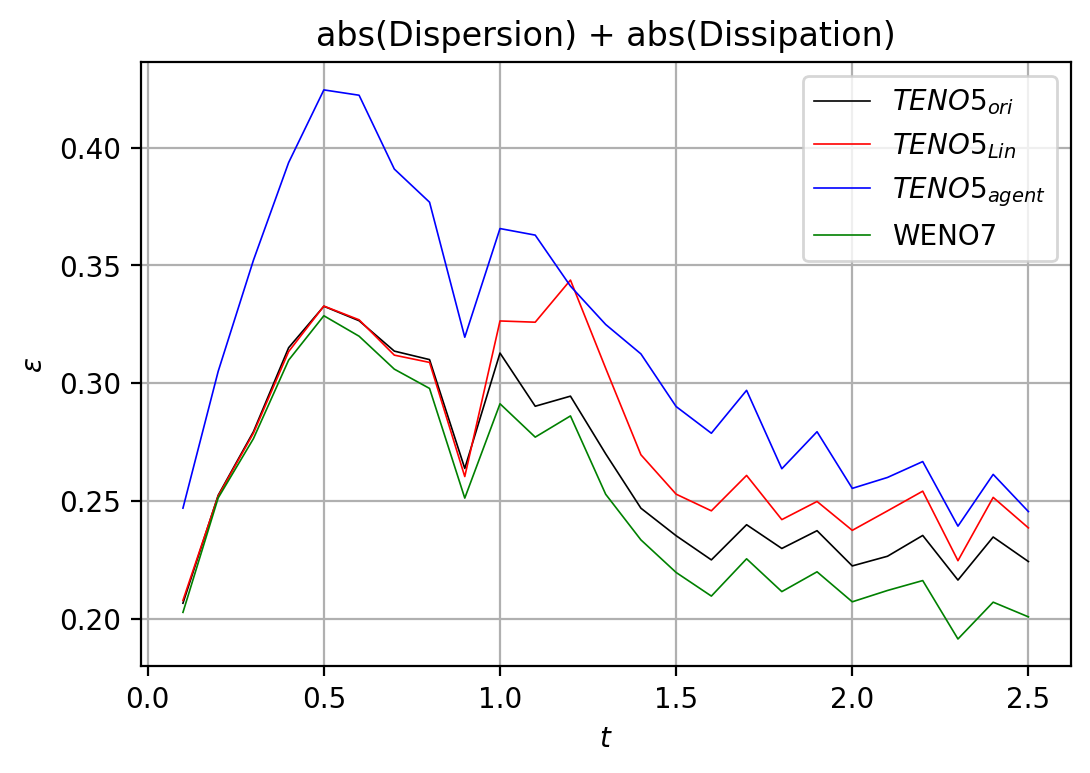

In [13]:
plt.figure(dpi=200)
colors = ["black", "red", "blue", "green", "orange"]
for i, label in enumerate(labels):
    plt.plot(timesteps, abs_numerical_dict[i], label=label, color=colors[i], linewidth=0.6)
plt.legend()
plt.title("abs(Dispersion) + abs(Dissipation)")
plt.ylabel("$\epsilon$")
plt.xlabel("$t$")
plt.grid()
# plt.show()
# plt.savefig("full_implosion_figures/abs_sum_rate.jpg")

849.1443888655892
854.9402072381425
877.4821998060639
853.463743880065


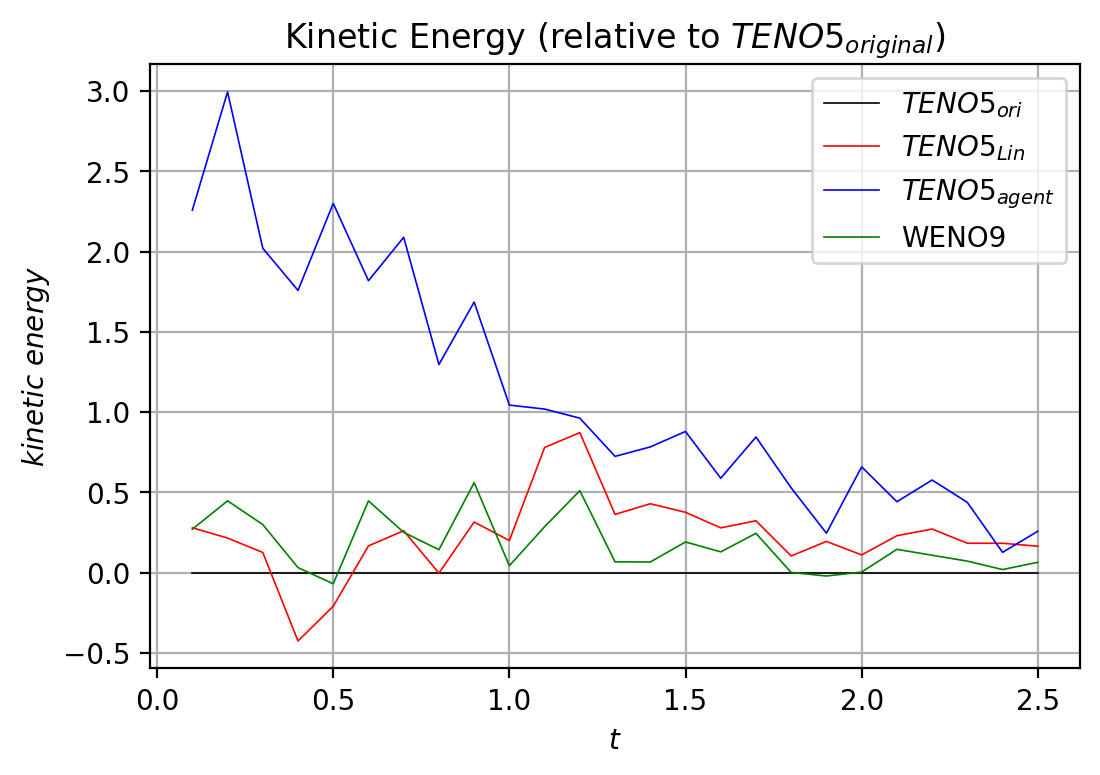

In [26]:
plt.figure(dpi=200)
colors = ["black", "red", "blue", "green", "orange"]
for i, label in enumerate(labels):
    ke_dict[i] = np.array(ke_dict[i])
    plt.plot(timesteps, ke_dict[i]-ke_dict[0], label=label, color=colors[i], linewidth=0.6)
    print(sum(ke_dict[i]))
plt.legend()
plt.title("Kinetic Energy (relative to $TENO5_{original}$)")
plt.ylabel("$kinetic\ energy$")
plt.xlabel("$t$")
plt.grid()

plt.savefig("/media/yiqi/Fengyiqi/TUM/RL/grid_search_figures/kinetic_compare.jpg")

In [15]:
plt.figure(dpi=200)
colors = ["black", "red", "blue", "green", "orange"]
for i, q in enumerate(q_list):
    plt.plot(timesteps, dissipation_dict[q], label="q="+str(q), color=colors[i], linewidth=0.6)
    plt.plot(timesteps, dispersion_dict[q], color=colors[i], linewidth=0.6)
plt.legend()
plt.grid()
plt.show()

plt.figure(dpi=200)
for i, q in enumerate(q_list):
    plt.plot(timesteps, abs_numerical_dict[q], label="q="+str(q), color=colors[i], linewidth=0.6)
plt.legend()
plt.grid()
plt.show()

plt.figure(dpi=200)
for i, q in enumerate(q_list):
    plt.plot(timesteps, ke_dict[q] - ke_dict[6], label="q="+str(q), color=colors[i], linewidth=0.6)
plt.legend()
plt.grid()
plt.show()

KeyError: 6

<Figure size 1200x800 with 0 Axes>

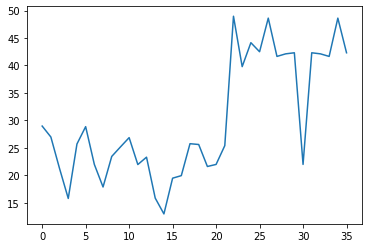

In [87]:
plt.plot(reward_his)

In [16]:
freeshear = FreeShearFlow(results_folder="full_implosion_test/full_implosion_ori/domain/", result_filename="data_2.500*.h5")
vel_x = freeshear.result["velocity"]["velocity_x"]
vel_y = freeshear.result["velocity"]["velocity_y"]
density = freeshear.result["density"]
x = 0.4 / 64
ke = 0.5 * density * (vel_x**2 + vel_y**2)
numerical = np.abs(freeshear.result["numerical_dissipation_rate"]).sum()

spectrum_data = freeshear._create_spectrum()
freeshear.spectrum_data = spectrum_data
reference = freeshear._calculate_reference()

fig, ax = plt.subplots(dpi=150)
ax.set_title(f"Kinetic Energy Spectrum at t=2.5")
ax.set_xlabel(r"k (wavenumber)")
ax.set_ylabel(r"TKE of the k$^{th}$ wavenumber")

ax.loglog(np.arange(0, 32),
          spectrum_data[0:32, 1],
          'k',
          label=f'simulation (k<{32})')
ax.loglog(np.arange(32, spectrum_data.shape[0]),
          spectrum_data[32:, 1],
          'k--',
          label=f'simulation (k>={32})')
ax.loglog(spectrum_data[:, 0].squeeze(), reference, 'r', label='reference')
ax.legend(loc='lower left')
ax.set_ylim(10 ** -15, 1)
ax.grid(which='both')

ke.sum(), numerical

FileNotFoundError: [Errno 2] No such file or directory: 'full_implosion_test/full_implosion_ori/domain/'

/home/yiqi/Software/envs/gpytorch/lib/python3.8/site-packages/boiles/objective/freeshear.py:144: RuntimeWarning: divide by zero encountered in power
  reference = A * np.power(self.spectrum_data[:, 0], -5 / 3).reshape(-1, 1)


(15.874066203085617, 0.24554259186980434)

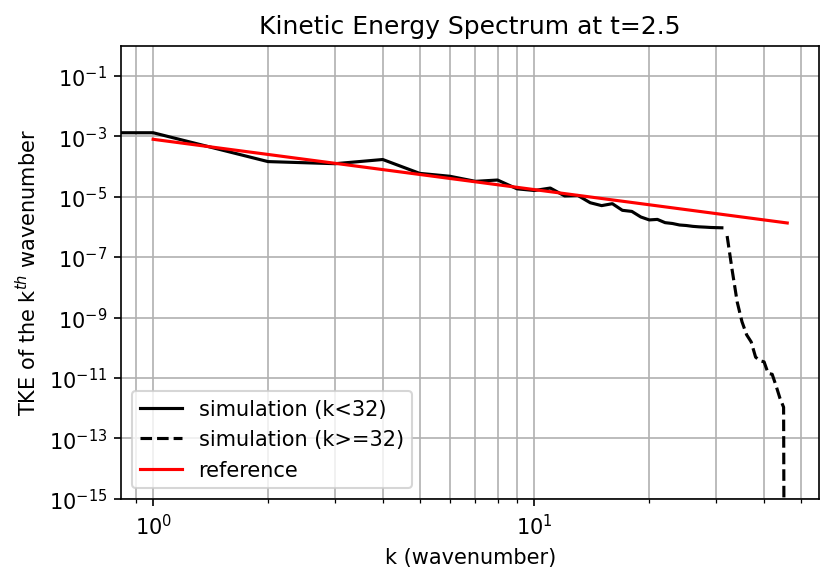

In [17]:
freeshear = FreeShearFlow(results_folder="runtime_data/full_implosion_64_2.500/domain/", result_filename="data_2.500*.h5")
vel_x = freeshear.result["velocity"]["velocity_x"]
vel_y = freeshear.result["velocity"]["velocity_y"]
density = freeshear.result["density"]
x = 0.4 / 64
ke = 0.5 * density * (vel_x**2 + vel_y**2)
numerical = np.abs(freeshear.result["numerical_dissipation_rate"]).sum()

spectrum_data = freeshear._create_spectrum()
freeshear.spectrum_data = spectrum_data
reference = freeshear._calculate_reference()

fig, ax = plt.subplots(dpi=150)
ax.set_title(f"Kinetic Energy Spectrum at t=2.5")
ax.set_xlabel(r"k (wavenumber)")
ax.set_ylabel(r"TKE of the k$^{th}$ wavenumber")

ax.loglog(np.arange(0, 32),
          spectrum_data[0:32, 1],
          'k',
          label=f'simulation (k<{32})')
ax.loglog(np.arange(32, spectrum_data.shape[0]),
          spectrum_data[32:, 1],
          'k--',
          label=f'simulation (k>={32})')
ax.loglog(spectrum_data[:, 0].squeeze(), reference, 'r', label='reference')
ax.legend(loc='lower left')
ax.set_ylim(10 ** -15, 1)
ax.grid(which='both')

ke.sum(), numerical